# Simple Microscope Simulation

This notebook demonstrates the individual components of a simple microscope model, then combines them into a complete simulation using the `simple_microscope` function. 

## Overview

A simple microscope forward model consists of the following elements:
1. **Sample** - A USAF 1951 resolution test pattern
2. **Linear Interaction** - Light interacts with the sample
3. **Optical Zoom** - Magnification by the objective lens
4. **Circular Aperture** - Limits the numerical aperture
5. **Fraunhofer Propagation** - Far-field propagation to the camera

## Imports

In [1]:
import janssen as jns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as cmo
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle

In [2]:
jns.__version__

'2025.10.4'

In [3]:
%load_ext autoreload
%autoreload 2

## Define Simulation Parameters

We create a sample that is:
- 2.5 mm x 2.5 mm in physical size
- 0.5 micron pixel size
- This gives us 5000 x 5000 pixels

In [4]:
pixel_size = 0.5e-6  # 0.5 microns
num_pixels = 4096
fov = pixel_size * num_pixels  # field of view
wavelength = 800e-9  # 800 nm (Ar laser)

print(f"Pixel size: {pixel_size * 1e6:.1f} microns")
print(f"Number of pixels: {num_pixels} x {num_pixels}")
print(f"Field of view: {fov * 1e3:.2f} mm")
print(f"Wavelength: {wavelength * 1e9:.0f} nm")

Pixel size: 0.5 microns
Number of pixels: 4096 x 4096
Field of view: 2.05 mm
Wavelength: 800 nm


## 1. Create USAF 1951 Test Pattern Sample

The USAF 1951 resolution test chart is a standard for measuring optical resolution. It consists of groups of bar patterns at different sizes.

In [ ]:
usaf_sample = jns.models.generate_usaf_pattern(
    image_size=num_pixels,
    auto=True,
    pixel_size=pixel_size,
    max_phase=jnp.pi,
)

print(f"Sample shape: {usaf_sample.sample.shape}")
print(f"Sample dx: {usaf_sample.dx * 1e6:.2f} microns")

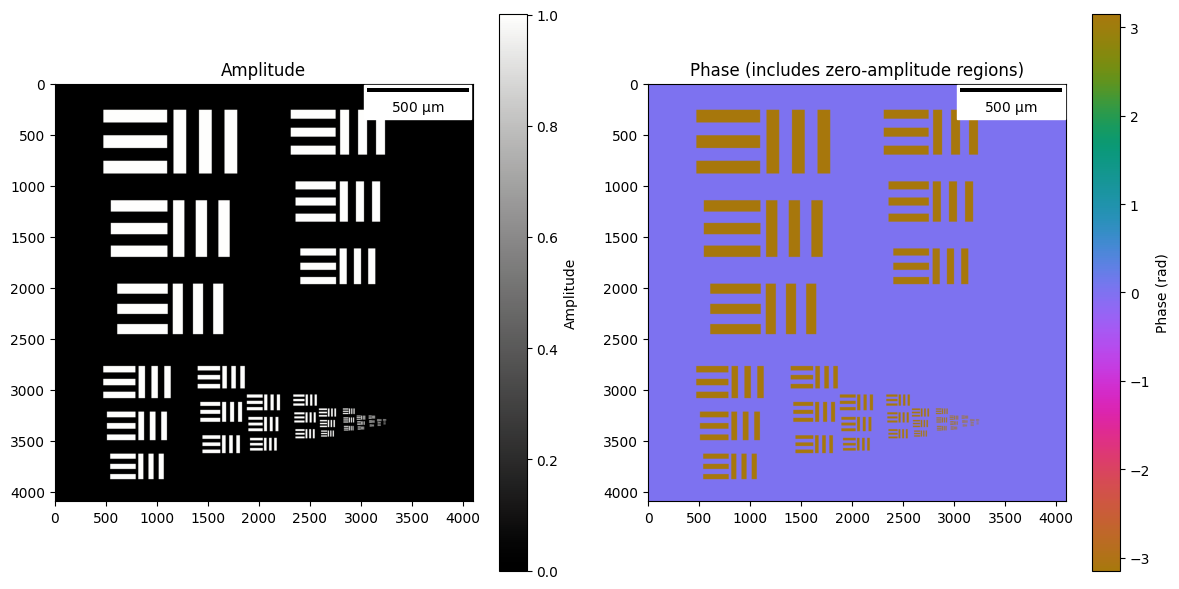

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

amp = jnp.abs(usaf_sample.sample)
phase = jnp.angle(usaf_sample.sample)

# Amplitude
im0 = axes[0].imshow(amp, cmap=cmo.gray)
axes[0].set_title("Amplitude")
scalebar = ScaleBar(pixel_size, "m", length_fraction=0.25, color="black")
axes[0].add_artist(scalebar)
plt.colorbar(im0, ax=axes[0], label="Amplitude")

# Phase (circular colormap - ideal for phase wrapping)
im1 = axes[1].imshow(phase, cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[1].set_title("Phase (includes zero-amplitude regions)")
scalebar = ScaleBar(pixel_size, "m", length_fraction=0.25, color="black")
axes[1].add_artist(scalebar)
plt.colorbar(im1, ax=axes[1], label="Phase (rad)")

plt.tight_layout()
plt.show()

## 2. Create Illumination Wavefront

We create a collimated (plane wave) illumination to interact with the sample.

In [ ]:
illumination_size = 256

lightwave = jns.models.plane_wave(
    wavelength=wavelength,
    dx=pixel_size,
    grid_size=(illumination_size, illumination_size),
    amplitude=1.0,
)

print(f"Illumination field shape: {lightwave.field.shape}")
print(f"Illumination wavelength: {lightwave.wavelength * 1e9:.0f} nm")
print(f"Illumination dx: {lightwave.dx * 1e6:.2f} microns")

Illumination field shape: (256, 256)
Illumination wavelength: 800 nm
Illumination dx: 0.50 microns


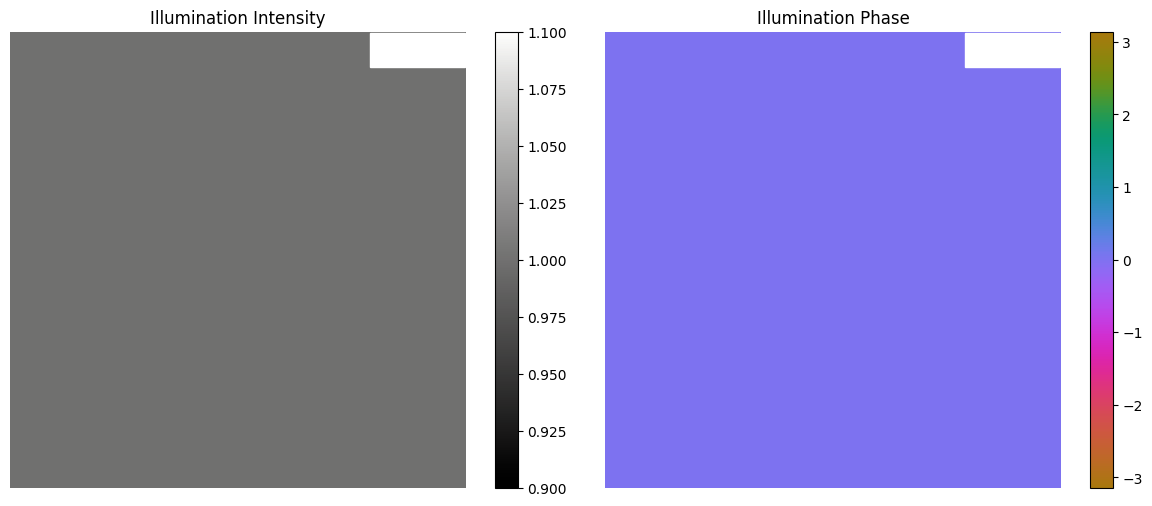

In [ ]:
# Visualize the illumination
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(lightwave.field) ** 2, cmap=cmo.gray)
axes[0].set_title("Illumination Intensity")
scalebar = ScaleBar(lightwave.dx, "m", length_fraction=0.25, color="white")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    jnp.angle(lightwave.field), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi
)
axes[1].set_title("Illumination Phase")
scalebar = ScaleBar(lightwave.dx, "m", length_fraction=0.25, color="white")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 3. Linear Interaction - Light Through Sample

The `linear_interaction` function models how light passes through a sample. The sample is treated as a complex transmission function that multiplies the incoming wavefront.

Sample region shape: (256, 256)


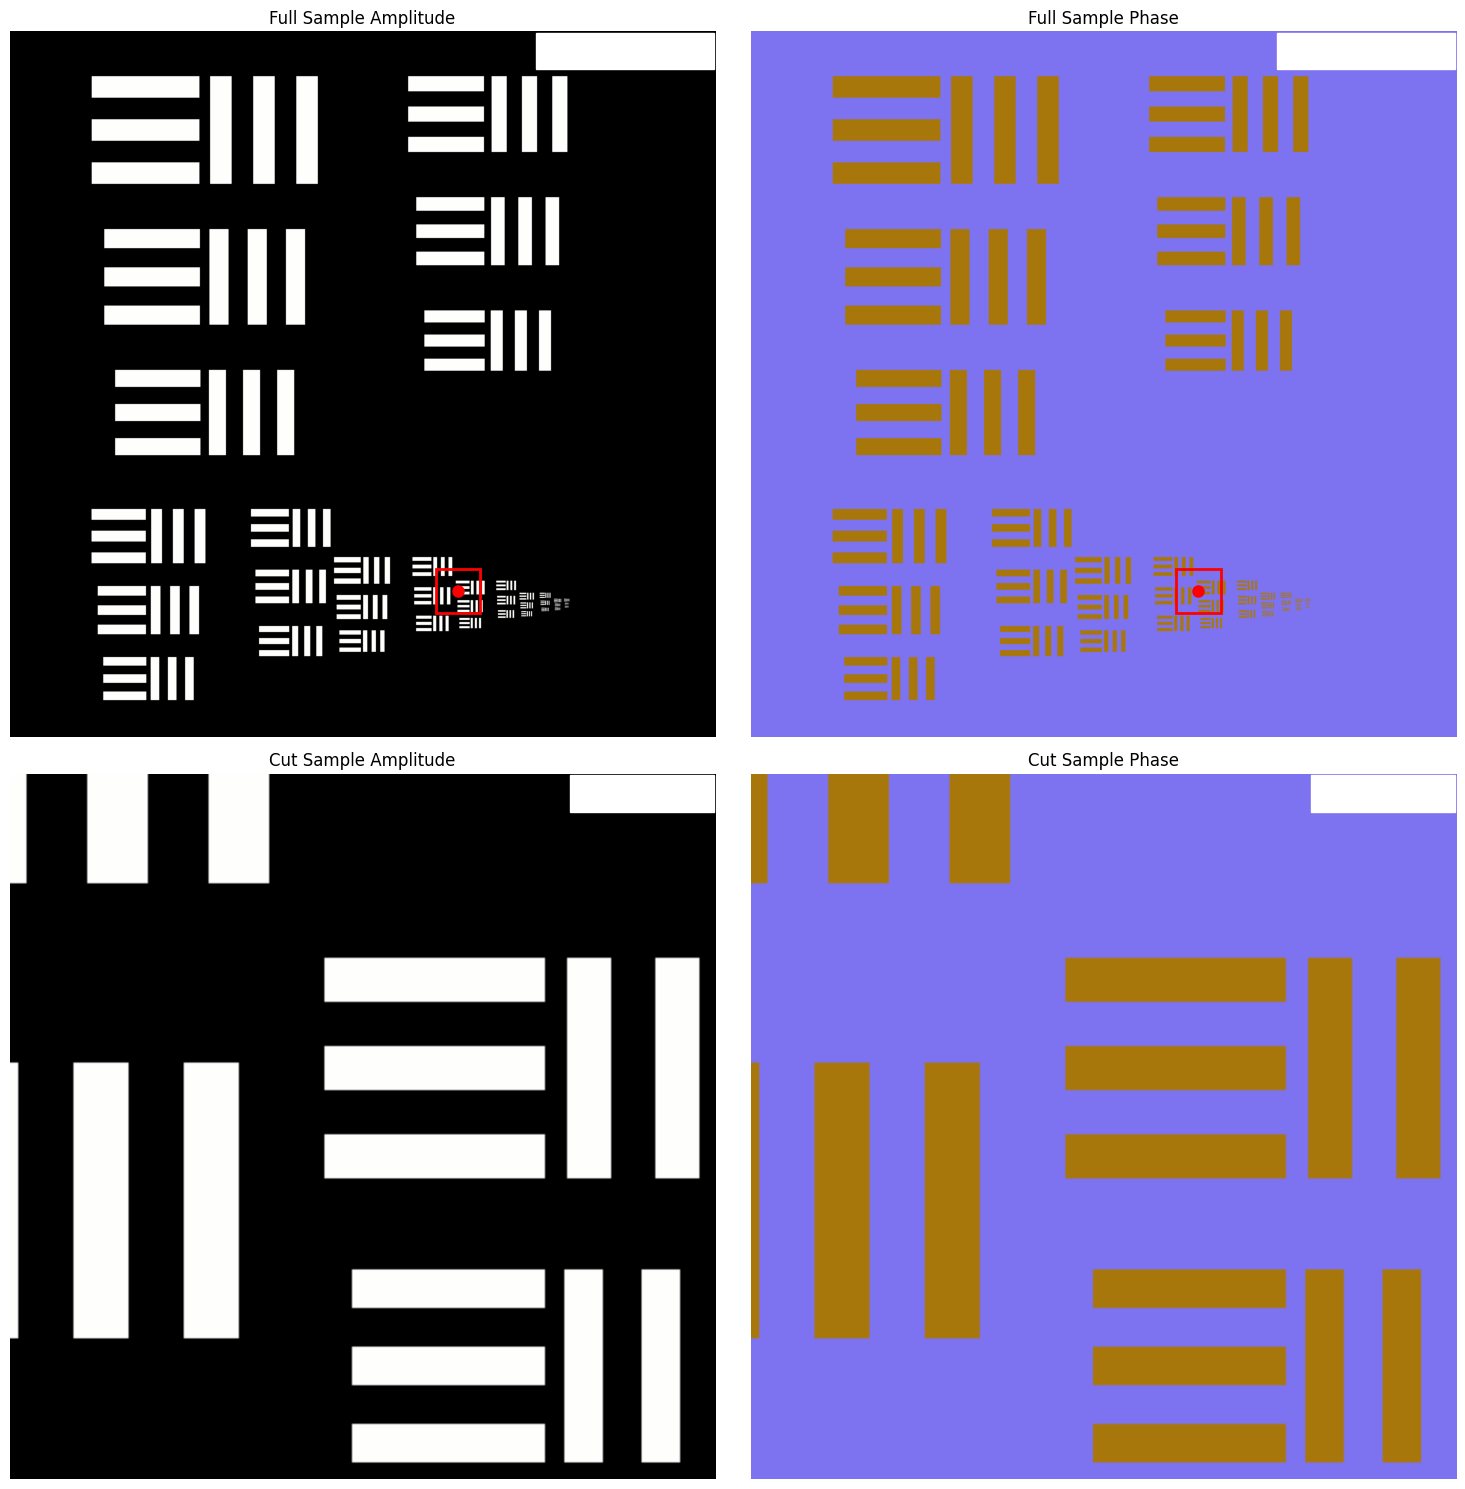

In [ ]:
center = (3250, 2600)
half_size = illumination_size // 2
sample_cut = usaf_sample.sample[
    center[0] - half_size : center[0] + half_size,
    center[1] - half_size : center[1] + half_size,
]

sample_region = jns.utils.make_sample_function(
    sample=sample_cut,
    dx=pixel_size,
)

print(f"Sample region shape: {sample_region.sample.shape}")

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

im00 = axes[0, 0].imshow(jnp.abs(usaf_sample.sample), cmap=cmo.gray)
axes[0, 0].set_title("Full Sample Amplitude")
scalebar = ScaleBar(usaf_sample.dx, "m", length_fraction=0.25, color="white")
axes[0, 0].add_artist(scalebar)
axes[0, 0].axis("off")

# Add red box showing where the cut sample comes from
# center is (y, x) tuple, Rectangle takes (x, y) for bottom-left corner
center_y, center_x = center
box_x = center_x - half_size
box_y = center_y - half_size
rect = Rectangle(
    (box_x, box_y),
    illumination_size,
    illumination_size,
    linewidth=2,
    edgecolor="red",
    facecolor="none",
)
axes[0, 0].add_patch(rect)
# Add center dot (plot takes x, y order)
axes[0, 0].plot(center_x, center_y, "ro", markersize=8)

im01 = axes[0, 1].imshow(
    jnp.angle(usaf_sample.sample), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi
)
axes[0, 1].set_title("Full Sample Phase")
scalebar = ScaleBar(usaf_sample.dx, "m", length_fraction=0.25, color="white")
axes[0, 1].add_artist(scalebar)
axes[0, 1].axis("off")

# Add matching box and dot to phase image
rect2 = Rectangle(
    (box_x, box_y),
    illumination_size,
    illumination_size,
    linewidth=2,
    edgecolor="red",
    facecolor="none",
)
axes[0, 1].add_patch(rect2)
axes[0, 1].plot(center_x, center_y, "ro", markersize=8)

im10 = axes[1, 0].imshow(jnp.abs(sample_region.sample), cmap=cmo.gray)
axes[1, 0].set_title("Cut Sample Amplitude")
scalebar = ScaleBar(sample_region.dx, "m", length_fraction=0.25, color="white")
axes[1, 0].add_artist(scalebar)
axes[1, 0].axis("off")

im11 = axes[1, 1].imshow(
    jnp.angle(sample_region.sample), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi
)
axes[1, 1].set_title("Cut Sample Phase")
scalebar = ScaleBar(sample_region.dx, "m", length_fraction=0.25, color="white")
axes[1, 1].add_artist(scalebar)
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Apply linear interaction
after_sample = jns.scopes.linear_interaction(
    sample=sample_region,
    light=lightwave,
)

print(f"After sample field shape: {after_sample.field.shape}")
print(f"After sample dx: {after_sample.dx * 1e6:.2f} microns")

After sample field shape: (256, 256)
After sample dx: 0.50 microns


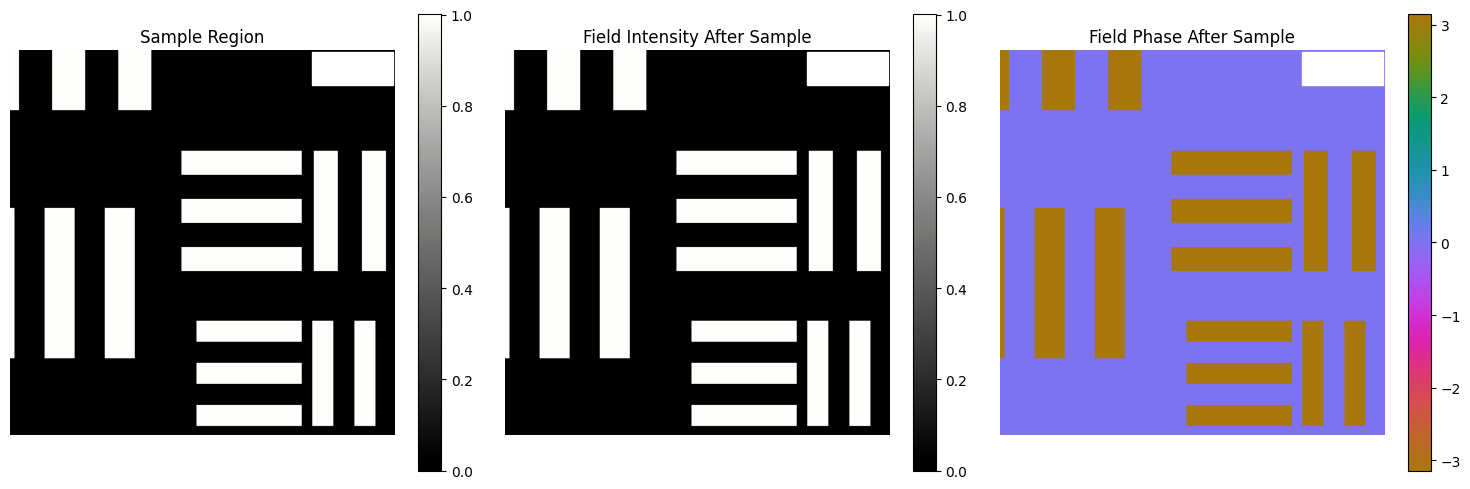

In [ ]:
# Visualize the field after interacting with the sample
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(jnp.abs(sample_region.sample), cmap=cmo.gray)
axes[0].set_title("Sample Region")
scalebar = ScaleBar(sample_region.dx, "m", length_fraction=0.25, color="white")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(after_sample.field) ** 2, cmap=cmo.gray)
axes[1].set_title("Field Intensity After Sample")
scalebar = ScaleBar(after_sample.dx, "m", length_fraction=0.25, color="white")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(
    jnp.angle(after_sample.field), cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi
)
axes[2].set_title("Field Phase After Sample")
scalebar = ScaleBar(after_sample.dx, "m", length_fraction=0.25, color="white")
axes[2].add_artist(scalebar)
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

## 4. Optical Zoom - Magnification

The `optical_zoom` function models the magnification from the objective lens. It scales the pixel size (dx) by the zoom factor while keeping the array size constant.

In [ ]:
# Apply optical zoom (magnification)
zoom_factor = 10.0  # 10x magnification

zoomed_wave = jns.prop.optical_zoom(after_sample, zoom_factor)

print(f"Before zoom dx: {after_sample.dx * 1e6:.2f} microns")
print(f"After zoom dx: {zoomed_wave.dx * 1e6:.2f} microns")
print(f"Magnification achieved: {zoomed_wave.dx / after_sample.dx:.1f}x")

Before zoom dx: 0.50 microns
After zoom dx: 5.00 microns
Magnification achieved: 10.0x


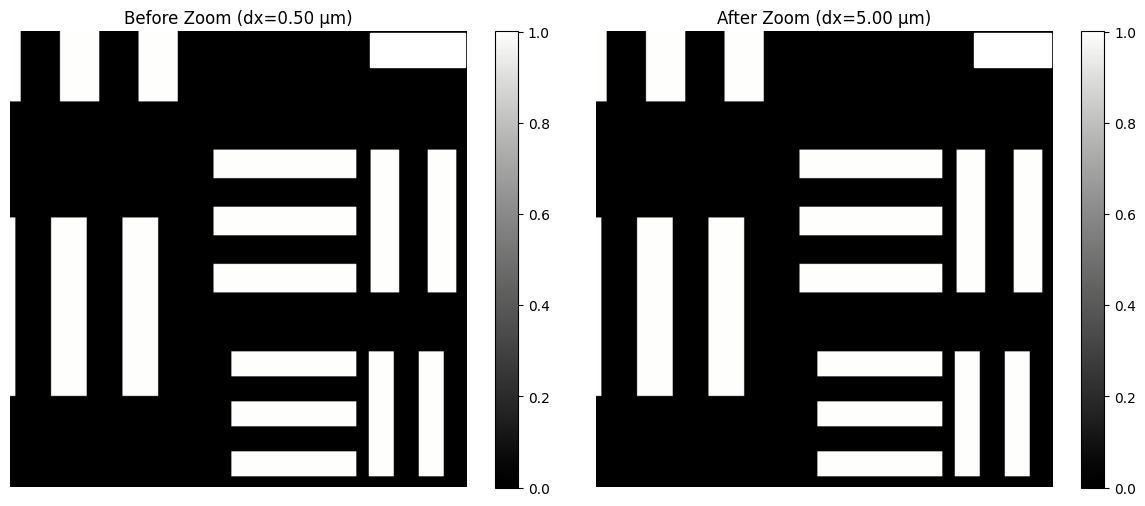

In [ ]:
# Visualize the zoomed field
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(after_sample.field) ** 2, cmap=cmo.gray)
axes[0].set_title(f"Before Zoom (dx={after_sample.dx*1e6:.2f} µm)")
scalebar = ScaleBar(after_sample.dx, "m", length_fraction=0.25, color="white")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(zoomed_wave.field) ** 2, cmap=cmo.gray)
axes[1].set_title(f"After Zoom (dx={zoomed_wave.dx*1e6:.2f} µm)")
scalebar = ScaleBar(zoomed_wave.dx, "m", length_fraction=0.25, color="white")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 5. Circular Aperture - Numerical Aperture Limit

The `circular_aperture` function models the limiting aperture of the optical system, which determines the numerical aperture and thus the resolution.

In [ ]:
# Apply circular aperture
# The aperture diameter determines the NA of the system
aperture_diameter = 1e-3  # 1 mm aperture

after_aperture = jns.optics.circular_aperture(
    zoomed_wave,
    diameter=aperture_diameter,
)

print(f"Aperture diameter: {aperture_diameter * 1e3:.1f} mm")

Aperture diameter: 1.0 mm


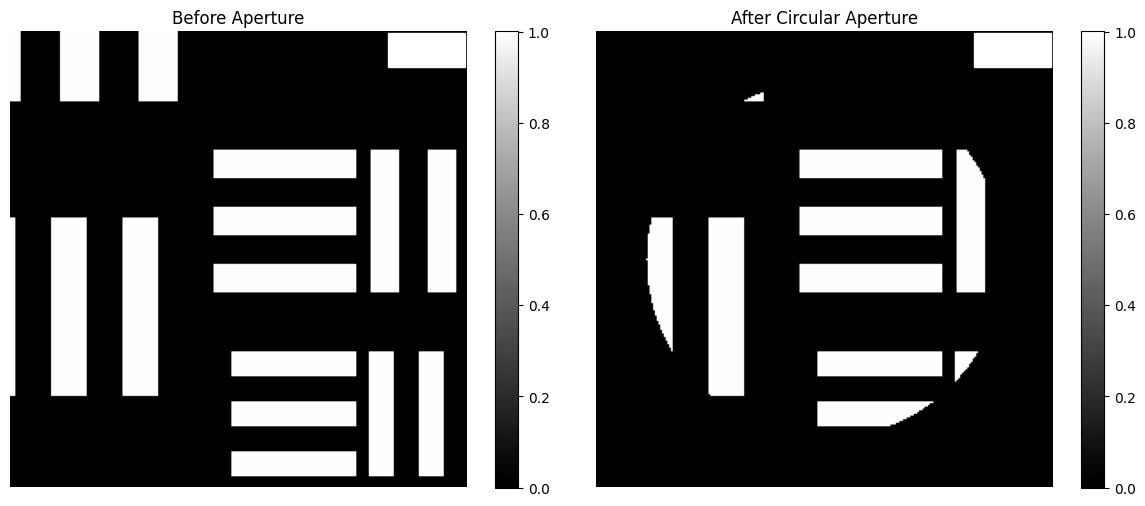

In [ ]:
# Visualize the effect of the aperture
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(jnp.abs(zoomed_wave.field) ** 2, cmap=cmo.gray)
axes[0].set_title("Before Aperture")
scalebar = ScaleBar(zoomed_wave.dx, "m", length_fraction=0.25, color="white")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(jnp.abs(after_aperture.field) ** 2, cmap=cmo.gray)
axes[1].set_title("After Circular Aperture")
scalebar = ScaleBar(
    after_aperture.dx, "m", length_fraction=0.25, color="white"
)
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 6. Fraunhofer Propagation - To Camera Plane

The `fraunhofer_prop_scaled` function models far-field (Fraunhofer) diffraction, which is appropriate for propagation from the aperture plane to the camera when the propagation distance is large.

In [ ]:
detector_pixel_size = jnp.array(16 / 1000000)

In [ ]:
# Propagate to camera plane
travel_distance = 0.15  # 100 mm to camera

at_camera = jns.prop.fraunhofer_prop_scaled(
    after_aperture, travel_distance, output_dx=detector_pixel_size
)

print(f"Propagation distance: {travel_distance * 1e3:.0f} mm")
print(f"Camera plane dx: {at_camera.dx * 1e6:.2f} microns")

Propagation distance: 150 mm
Camera plane dx: 16.00 microns


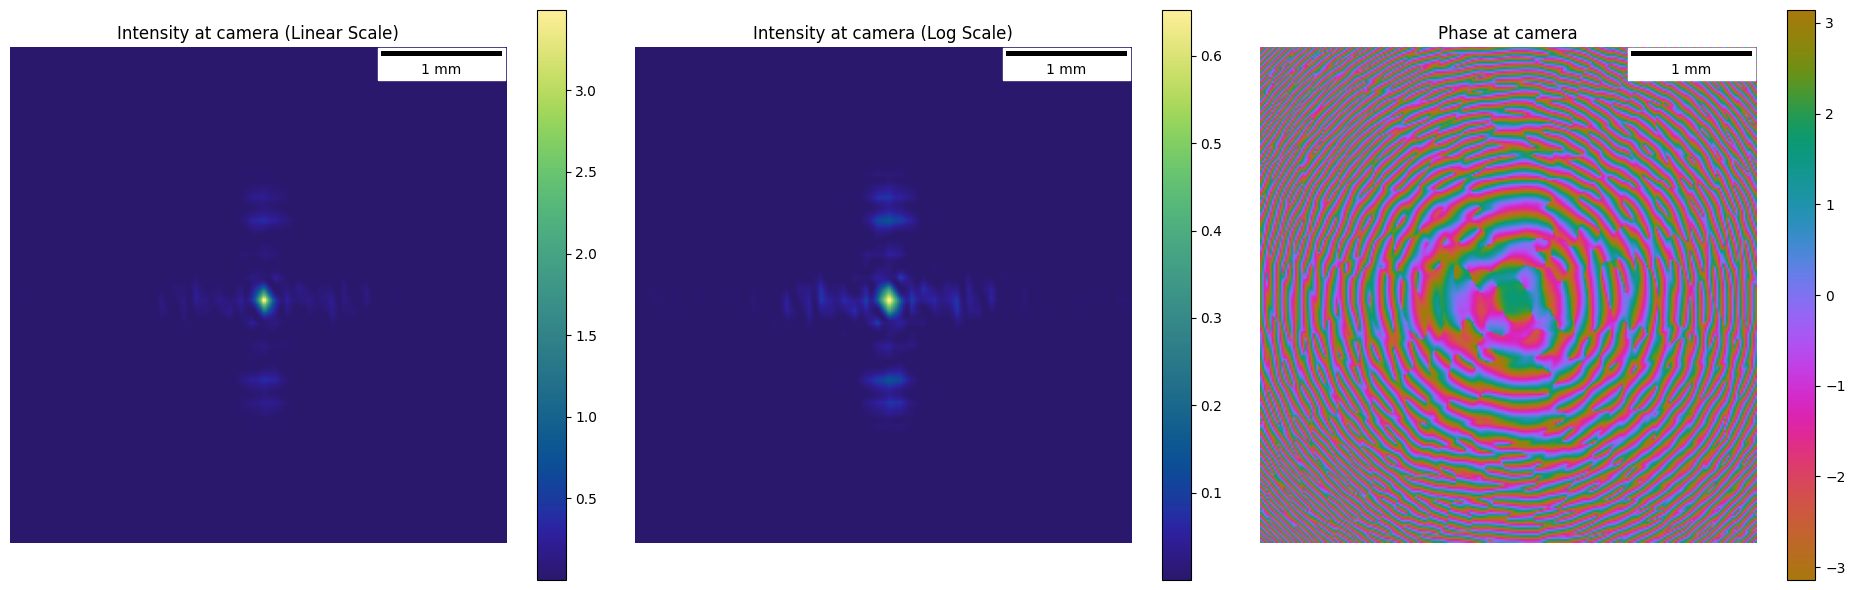

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(19, 6))

im0 = axes[0].imshow(
    jns.optics.field_intensity(at_camera.field), cmap=cmo.haline
)
axes[0].set_title("Intensity at camera (Linear Scale)")
scalebar = ScaleBar(at_camera.dx, "m", length_fraction=0.25, color="black")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

# Combined function result
im1 = axes[1].imshow(
    jnp.log10(1 + jns.optics.field_intensity(at_camera.field)), cmap=cmo.haline
)
axes[1].set_title("Intensity at camera (Log Scale)")
scalebar = ScaleBar(at_camera.dx, "m", length_fraction=0.25, color="black")
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

# Log scale comparison
im2 = axes[2].imshow(jnp.angle(at_camera.field), cmap=cmo.phase)
axes[2].set_title("Phase at camera")
scalebar = ScaleBar(at_camera.dx, "m", length_fraction=0.25, color="black")
axes[2].add_artist(scalebar)
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

## 7. Complete Pipeline Comparison

Let's compare using the individual steps versus the built-in `simple_diffractogram` function.

In [ ]:
at_camera_combined = jns.scopes.simple_diffractogram(
    sample_cut=sample_region,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=detector_pixel_size,
)

print(f"Diffractogram shape: {at_camera_combined.image.shape}")
print(f"Diffractogram dx: {at_camera_combined.dx * 1e6:.2f} microns")

Diffractogram shape: (256, 256)
Diffractogram dx: 16.00 microns


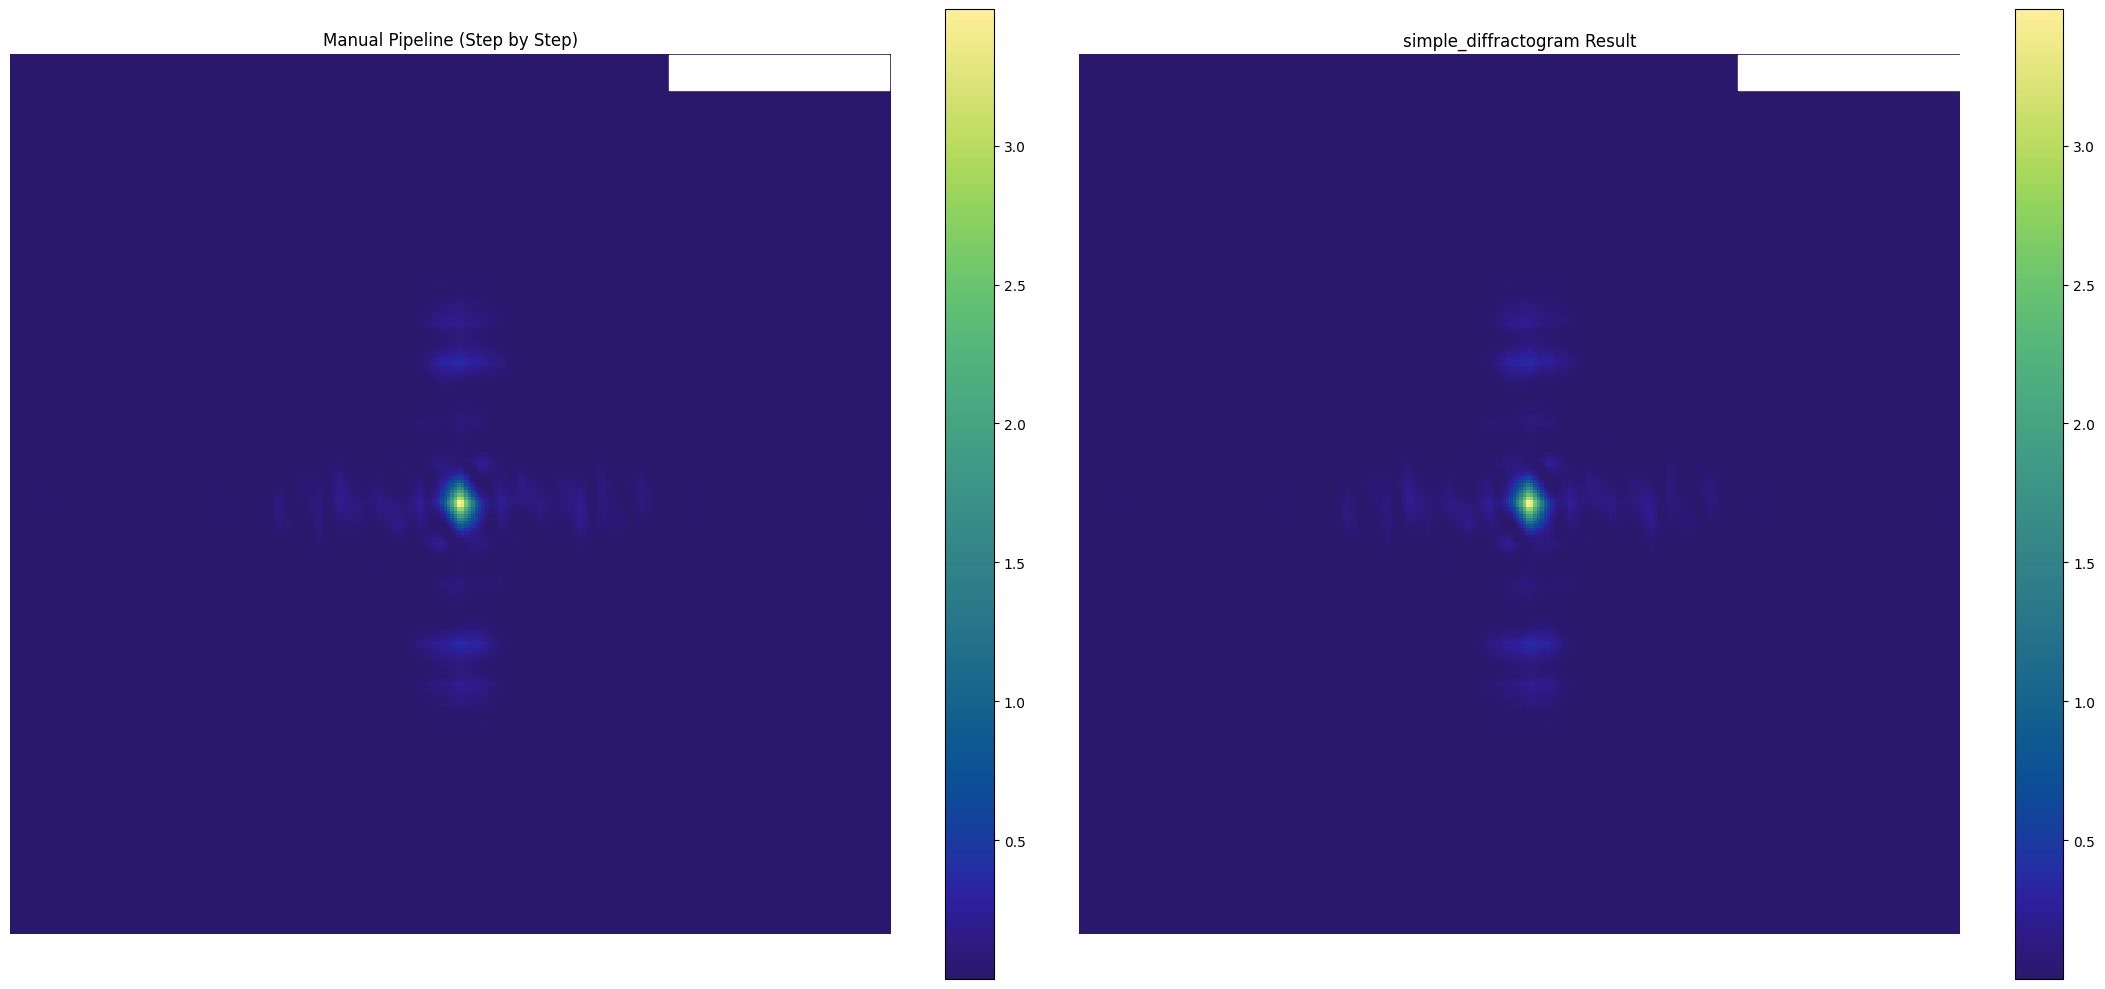

Max difference: 0.00e+00


In [ ]:
# Visualize the diffractogram and compare with manual steps
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# Manual pipeline result
im0 = axes[0].imshow(
    jns.optics.field_intensity(at_camera.field), cmap=cmo.haline
)
axes[0].set_title("Manual Pipeline (Step by Step)")
scalebar = ScaleBar(at_camera.dx, "m", length_fraction=0.25, color="white")
axes[0].add_artist(scalebar)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0])

# Combined function result
im1 = axes[1].imshow(at_camera_combined.image, cmap=cmo.haline)
axes[1].set_title("simple_diffractogram Result")
scalebar = ScaleBar(
    at_camera_combined.dx, "m", length_fraction=0.25, color="white"
)
axes[1].add_artist(scalebar)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# Verify they match
print(
    f"Max difference: {jnp.max(jnp.abs(jns.optics.field_intensity(at_camera.field) - at_camera_combined.image)):.2e}"
)

## 8. Full Microscope Simulation - Multiple Positions

The `simple_microscope` function calculates diffractograms at multiple sample positions in parallel using JAX's `vmap`. This is useful for ptychography or scanning microscopy.

**Note:** Due to JAX tracing limitations with `jax.image.resize`, we'll demonstrate manual position scanning using `diffractogram_noscale`.

In [ ]:
# Create scan positions centered on the same region as the single diffractogram test
scan_step = 15e-6  # step size in meters
scan_pixel = scan_step / usaf_sample.dx  # step size in pixels

# Use same center as the single diffractogram test: (y=3250, x=2600) pixels
# positions are (x, y) format
scope_center = jnp.array([2600, 3250])  # (x, y) in pixels

num_x_pixels = 20
num_y_pixels = 20
xx, yy = jnp.meshgrid(
    jnp.arange(num_x_pixels) * scan_pixel
    - (num_x_pixels - 1) * scan_pixel / 2,
    jnp.arange(num_y_pixels) * scan_pixel
    - (num_y_pixels - 1) * scan_pixel / 2,
)
x_positions = xx + scope_center[0]
y_positions = yy + scope_center[1]
positions = jnp.stack([x_positions.ravel(), y_positions.ravel()], axis=1)

print(f"Scan step (pixels): {scan_pixel:.2f}")
print(f"Scan step (microns): {scan_step*1e6:.2f}")
print(f"Scan center (pixels): x={scope_center[0]}, y={scope_center[1]}")
print(f"Number of scan positions: {len(positions)}")
print(
    f"X range (pixels): {positions[:, 0].min():.0f} to {positions[:, 0].max():.0f}"
)
print(
    f"Y range (pixels): {positions[:, 1].min():.0f} to {positions[:, 1].max():.0f}"
)

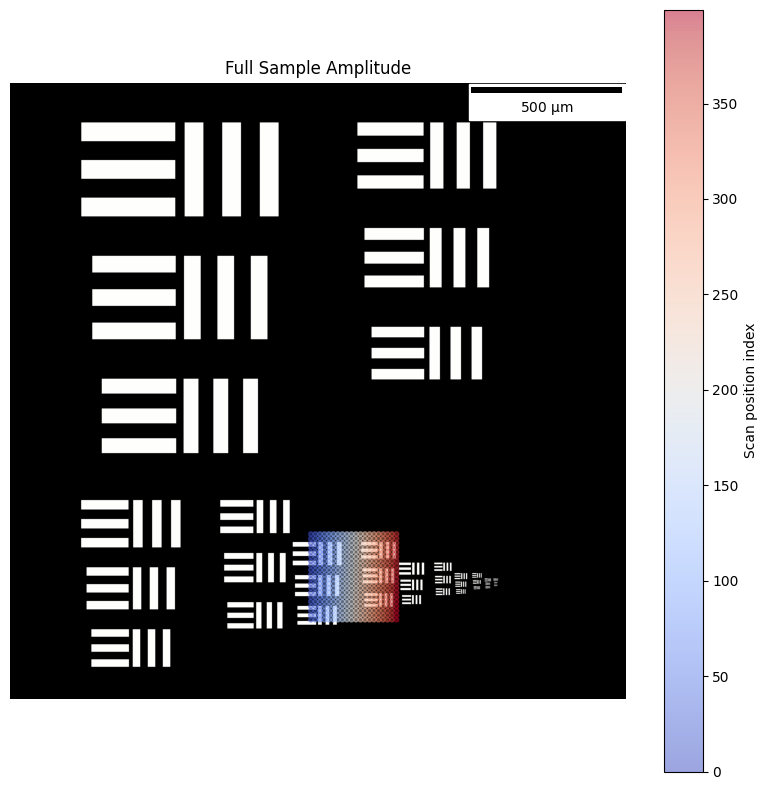

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

im00 = axes.imshow(jnp.abs(usaf_sample.sample), cmap=cmo.gray)
axes.set_title("Full Sample Amplitude")
scalebar = ScaleBar(usaf_sample.dx, "m", length_fraction=0.25, color="black")
axes.add_artist(scalebar)

# Add scan positions as dots (convert from meters to pixels)
scatter = axes.scatter(
    positions[:, 0],
    positions[:, 1],
    c=jnp.arange(len(positions)),
    cmap="coolwarm",
    s=10,
    alpha=0.5,
    marker="o",
)
plt.colorbar(scatter, ax=axes, label="Scan position index")
axes.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Convert pixel positions to meters for simple_microscope
positions_meters = positions * usaf_sample.dx

# Run simple_microscope with these positions
microscope_data = jns.scopes.simple_microscope(
    sample=usaf_sample,
    positions=positions_meters,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=detector_pixel_size,
)

print(f"Microscope data shape: {microscope_data.image_data.shape}")
print(f"Number of diffractograms: {microscope_data.image_data.shape[0]}")
print(f"Diffractogram size: {microscope_data.image_data.shape[1:]}")
print(f"Camera pixel size: {microscope_data.dx * 1e6:.2f} µm")

Microscope data shape: (400, 256, 256)
Number of diffractograms: 400
Diffractogram size: (256, 256)
Camera pixel size: 16.00 µm


In [ ]:
%timeit jns.scopes.simple_microscope(sample=usaf_sample,positions=positions_meters,lightwave=lightwave,zoom_factor=zoom_factor,aperture_diameter=aperture_diameter,travel_distance=travel_distance,camera_pixel_size=detector_pixel_size,)

4.34 s ± 70.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


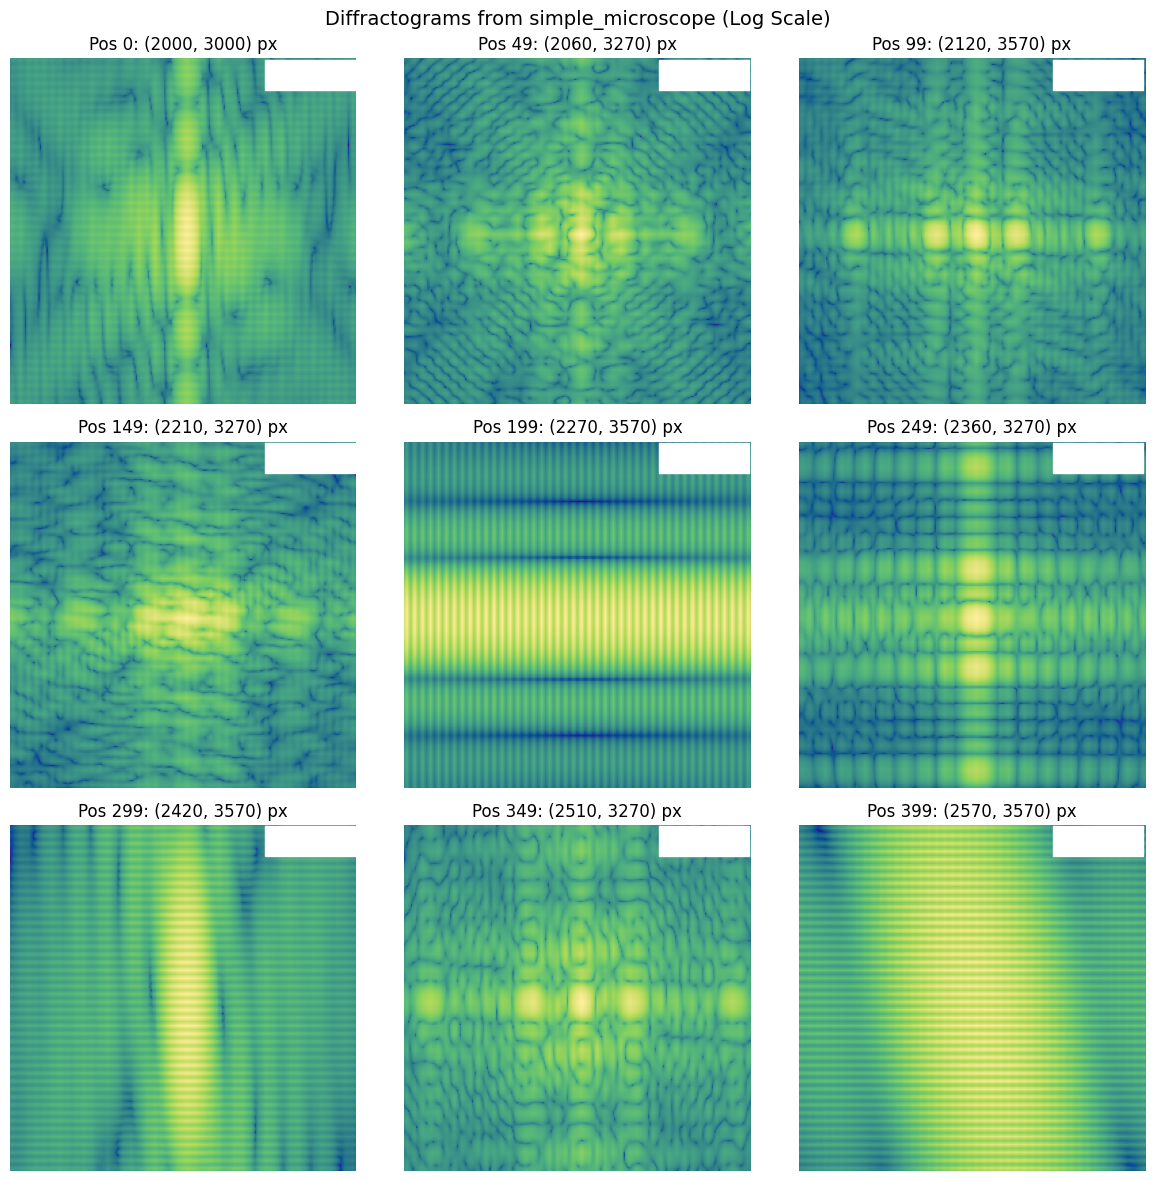

In [ ]:
# Visualize a few diffractograms from the scan
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Select 9 evenly spaced diffractograms to display
indices = jnp.linspace(0, len(positions) - 1, 9).astype(int)

for i, ax in enumerate(axes.flat):
    idx = int(indices[i])
    im = ax.imshow(
        jnp.log10(microscope_data.image_data[idx] + 1e-10), cmap=cmo.haline
    )
    pos = positions[idx]
    ax.set_title(f"Pos {idx}: ({pos[0]:.0f}, {pos[1]:.0f}) px")
    scalebar = ScaleBar(
        microscope_data.dx, "m", length_fraction=0.25, color="white"
    )
    ax.add_artist(scalebar)
    ax.axis("off")

plt.suptitle("Diffractograms from simple_microscope (Log Scale)", fontsize=14)
plt.tight_layout()
plt.show()